In [73]:
# necessary imports
import matplotlib.pyplot as plt
import cv2
import faiss
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.ndimage import gaussian_filter

from src.detection import augment_image
from src.utils import resize_mask_img, get_dataset_info
from src.backbones import get_model

data_root = "data"
mvtec_path = f"{data_root}/mvtec_anomaly_detection"
objects, object_anomalies, masking_default, rotation_default = get_dataset_info("MVTec", "informed")

In [ ]:
def score_single_image(image_test, image_ref_list, model, masking = True, rotation = True, use_faiss = True):
    features_ref = []

    # Extract reference features and set up the knn index (memory bank)
    for image_ref in image_ref_list:
        if rotation:
            img_augmented = augment_image(image_ref)
        else:
            img_augmented = [image_ref]

        for i in range(len(img_augmented)):
            image_ref = img_augmented[i]
            image_ref_tensor, _ = model.prepare_image(image_ref)
            features_ref_i = model.extract_features(image_ref_tensor)
            features_ref.append(features_ref_i)

    features_ref = np.concatenate(features_ref, axis=0)
    if use_faiss:
        knn_index1 = faiss.IndexFlatL2(features_ref.shape[1])
        faiss.normalize_L2(features_ref)
        knn_index1.add(features_ref)
    else:
        knn_index1 = NearestNeighbors(n_neighbors=1, metric="cosine")
        # normalize features
        features_ref = features_ref / np.linalg.norm(features_ref, axis=1)[:, None]
        knn_index1.fit(features_ref)

    # Extract test features
    image_tensor_test, grid_size2 = model.prepare_image(image_test)
    features_test = model.extract_features(image_tensor_test)

    if use_faiss:
        faiss.normalize_L2(features_test)
        distances, _ = knn_index1.search(features_test, k = 1)
        distances = distances / 2
    else:
        # normalize features
        features_test = features_test / np.linalg.norm(features_test, axis=1)[:, None]
        distances, _ = knn_index1.kneighbors(features_test, n_neighbors=1)
        
    # Filter out the relevant patches of test image
    if masking:
        mask2 = model.compute_background_mask_from_image(image_test, threshold=10, masking_type=masking)
        distances[~mask2] = 0.0
    else:
        mask2 = np.ones(features_test.shape[0], dtype=bool)

    # Compute anomaly score
    score_top1p = np.mean(sorted(distances, reverse = True)[:int(max(1,len(distances) * 0.01))])
    distances = distances.reshape(grid_size2)
    return score_top1p, distances, mask2

# Patch-based Anomaly Detection with AnomalyDINO (Demo)

## One-shot AD (classical)
1. Extract nominal features from reference sample
   - select relevant features by masking (optional, dependent on category, texture or object etc.)
   - augment by meaningful augmentations (here: rotation), optional
2. Extract features from test sample
   - select relevant features by masking, optional
3. Compute distances between test patches and closest nominal patch
   - anomaly score: max(patch_distances), some high quantile, etc.
   - anomaly map: upscale & smooth the patch distances

In [84]:
# Load DINOv2 model
model = get_model('dinov2_vits14', 'cuda', smaller_edge_size=32*20)

Loading model: dinov2_vits14
Device: cuda
Smaller edge size: 640


Using cache found in /home/dammsicw/.cache/torch/hub/facebookresearch_dinov2_main


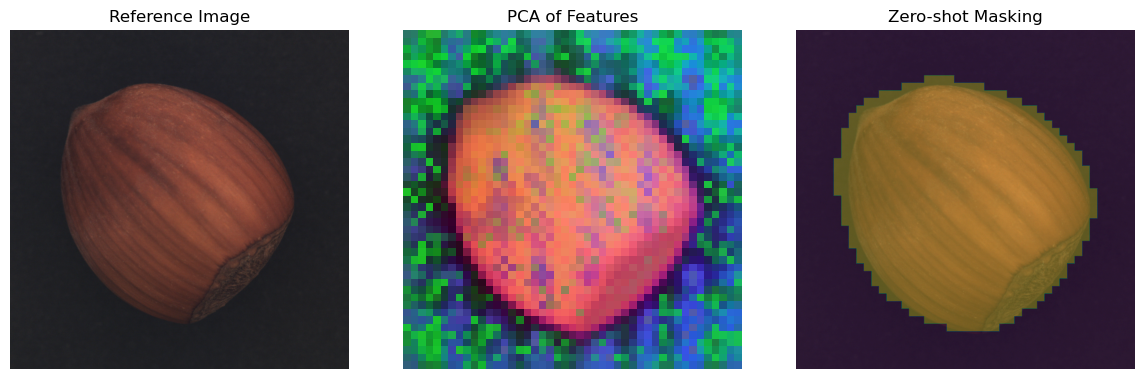

In [85]:
# Load reference image
object_name = "hazelnut" # change object/image as you like
img_name = "001.png"
image_ref = cv2.imread(f"{mvtec_path}/{object_name}/train/good/{img_name}")
image_ref = cv2.cvtColor(image_ref, cv2.COLOR_BGR2RGB)

masking = masking_default[object_name] # set masking = False for textures

# Compute features and mask
image_tensor1, grid_size1 = model.prepare_image(image_ref)
features_ref = model.extract_features(image_tensor1)
mask_ref = model.compute_background_mask(features_ref, grid_size1, threshold=10, masking_type=masking)
vis_image_ref = model.get_embedding_visualization(features_ref, grid_size1)

# Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(image_ref)
ax2.imshow(vis_image_ref)
resized_mask = resize_mask_img(mask_ref, image_ref.shape, grid_size1)
ax3.imshow(image_ref)
# prepare_mask
ax3.imshow(resize_mask_img(mask_ref, image_ref.shape, grid_size1), alpha=0.3)
# ax3.imshow(model.prepare_mask(mask_ref, image_ref.shape, grid_size1), alpha=0.3)
fig.tight_layout()
ax1.axis('off')
ax1.set_title("Reference Image")
ax2.axis('off')
ax2.set_title("PCA of Features")
ax3.axis('off')
ax3.set_title("Zero-shot Masking")
plt.show()

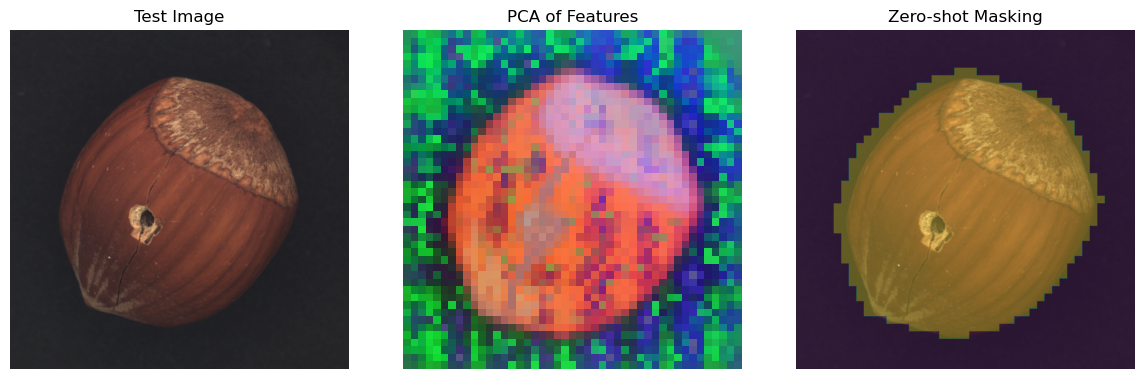

In [86]:
# Load test image
anomaly_type = "hole" # "good", "crack", "hole"... (depends on the object/product)
test_img_name = "006.png"

# Load test image from given anomaly type
image_test_path = f"{mvtec_path}/{object_name}/test/{anomaly_type}/{test_img_name}"
image_test = cv2.cvtColor(cv2.imread(image_test_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

# Compute features and mask
image_tensor2, grid_size2 = model.prepare_image(image_test)
features_test = model.extract_features(image_tensor2)
mask_test = model.compute_background_mask(features_test, grid_size2, threshold=10, masking_type=masking)
vis_image_test = model.get_embedding_visualization(features_test, grid_size2)

# Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(image_test)
ax2.imshow(vis_image_test)
resized_mask = resize_mask_img(mask_test, image_test.shape, grid_size2)
ax3.imshow(image_test)
ax3.imshow(resize_mask_img(mask_test, image_test.shape, grid_size2), alpha=0.3)

fig.tight_layout()
ax1.axis('off')
ax1.set_title("Test Image")
ax2.axis('off')
ax2.set_title("PCA of Features")
ax3.axis('off')
ax3.set_title("Zero-shot Masking")
plt.show()

## Score the test image

In [113]:
# read in k reference images (k-shot)
k = 4
image_ref_list = []

for i in range(k):
    image_ref_path = f"{mvtec_path}/{object_name}/train/good/{i+1:03d}.png"
    image_ref = cv2.cvtColor(cv2.imread(image_ref_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    image_ref_list.append(image_ref)

In [114]:
anomaly_score, patch_distances, mask_test = score_single_image(image_test, image_ref_list, model, masking = masking, rotation = False, use_faiss = True)
print(f"The predict anomaly score ({k}-shot) for this sample is ", anomaly_score)

The predict anomaly score (4-shot) for this sample is  0.43637863


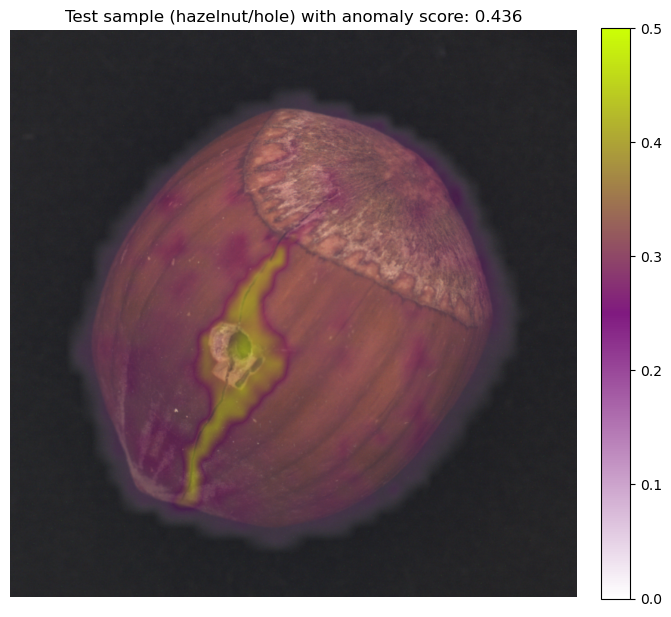

In [115]:
# plot anomaly map
from  matplotlib.colors import LinearSegmentedColormap
neon_violet = (0.5, 0.1, 0.5, 0.4)
neon_yellow = (0.8, 1.0, 0.02, 0.7)
colors = [(1.0, 1, 1.0, 0.0),  neon_violet, neon_yellow]
cmap = LinearSegmentedColormap.from_list("AnomalyMap", colors, N=256)

plt.figure(figsize=(8, 8))
plt.imshow(image_test, alpha=1.0)

d = patch_distances.flatten()
d = cv2.resize(d.reshape(grid_size2), (image_test.shape[1], image_test.shape[0]), interpolation = cv2.INTER_LINEAR)
d = gaussian_filter(d, sigma=4.0)
vmax = 0.5 # vmax may need to be adjusted differently for different objects, for hazelnut 0.5 is a good choice
plt.colorbar(plt.imshow(d, alpha=1.0, cmap=cmap, vmax=vmax), orientation='vertical', fraction=0.046, pad=0.04)

plt.axis('off')
plt.title(f"Test sample ({object_name}/{anomaly_type}) with anomaly score: {anomaly_score:.3f}")
plt.show()